# Проект для «Викишоп»

В распоряжении набор данных с разметкой о токсичности правок описания товара Интернет-магазин «Викишоп». Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель: Обучить модель классифицировать комментарии на позитивные и негативные, а также построить модель со значением метрики качества *F1* не меньше 0.75.

Задачи:
1. Подготовить данные.
2. Обучить разные модели.
3. Выбрать лучшую модель, сделать выводы.

## Подготовка

In [1]:
# загружаю библиотеки
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import wordnet, stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn. metrics import f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb

import re

from tqdm import tqdm
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lubov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lubov\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('C:/Users/Lubov/jupyter/ds/toxic_comments.csv', index_col=0)

In [3]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


In [4]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

In [5]:
df['toxic'].mean()

0.10161213369158527

Токсичных комментариев 10%, в дальнейших действиях буду учитывать дисбаланс классов.

Объявлю лемматизатор и функцию для очистки и лемматизации текстов "clear_text":

In [7]:
def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = pattern.split()
    lemm = []
    for i in range(len(clear)):
        lemm.append(wnl.lemmatize(clear[i]))
    return " ".join(lemm)


In [9]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wnl = WordNetLemmatizer()

df['text_lemma'] = df['text'].progress_apply(lambda x: " ".join([wnl.lemmatize(w, get_wordnet_pos(w)) for w in clear_text(x).split()]))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [29]:
display(df.head(10))
df.info()

,text,toxic,text_lemma
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations from me a well use the tool we...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense wa offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   text_lemma  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [30]:
# сохраню файл
df.to_csv('C:/Users/Lubov/jupyter/ds/lemm.csv')

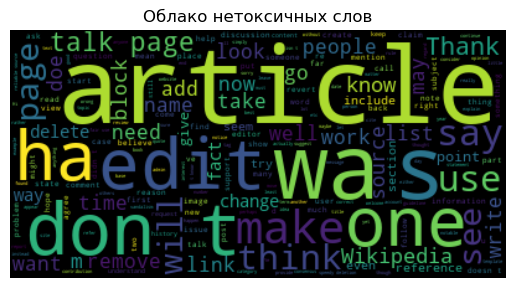

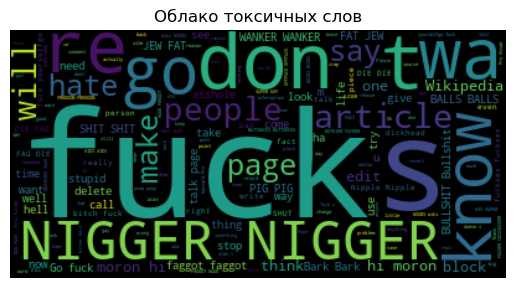

In [33]:
%matplotlib inline

text_raw = " ".join(df[df["toxic"]==0]['text_lemma'])
wordcloud = WordCloud().generate(text_raw) # строю облако слов

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Облако нетоксичных слов")
plt.show()

text_raw_toxic = " ".join(df[df["toxic"]==1]['text_lemma'])
wordcloud_toxic = WordCloud().generate(text_raw_toxic) # строю облако токсичных слов 

plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")
plt.title("Облако токсичных слов")
plt.show()

In [34]:
nltk.download('stopwords')#загружу список стоп-слов
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lubov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
#Объявлю две переменные: features — признаки и target — целевой признак.
features = df.drop('toxic',axis=1)
target = df['toxic']
#помню про дисбаланс классов, поэтому stratify=target
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, \
                                                                            random_state=12345, stratify=target)

display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(119469, 2)

(119469,)

(39823, 2)

(39823,)

In [36]:
# считаю величину TF-IDF
#Объявляю TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

In [37]:
#Выполняю векторизацию текстов
features_train = count_tf_idf.fit_transform(features_train.text_lemma)
display(features_train.shape)

(119469, 134523)

In [38]:
features_test = count_tf_idf.transform(features_test.text_lemma)
display(features_train.shape)

(119469, 134523)

### Вывод:

Количество токсичных комментариев - 10% от общего числа, это учту при построении моделей.
Тексты были очищены и лемматизированы. Для векторизации текстов применила TfidfVectorizer().
Полученный датасет разделила на обучающую и тестовые выборки.

## Обучение

В качестве моделей буду использовать Логистическую регрессию, Случайный лес,  LightGBM классификатор и CatBoost классификатор.

Логистическая регрессия

In [39]:
%%time

clf_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(features_train, target_train)
print(grid_lr.best_params_)

print('F1 модели Логистической регрессии на кросс-валидации:', grid_lr.best_score_)

{'C': 8, 'max_iter': 14}
F1 модели Логистической регрессии на кросс-валидации: 0.7547419707473767
CPU times: total: 2min 10s
Wall time: 2min 11s


RandomForestClassifier

In [42]:
%%time
#Подбираю оптимальные гиперпараметры для Случайного леса на кросс-валидации, указываю параметр class_weight = 'balanced'
forest = RandomForestClassifier(random_state=12345, class_weight='balanced', n_jobs=-1 )
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(20, 40, 10),
                     'max_depth': range(4, 8, 2),
                     'min_samples_leaf': range(3,5),
                     'min_samples_split': range(2,6,2)}

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring='f1', cv=3)
forest_grid.fit(features_train, target_train)
forest_params = forest_grid.best_params_
print(forest_params)

{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20}
CPU times: total: 55.5 s
Wall time: 3min 20s


In [43]:
print('F1 модели RandomForestClassifier на кросс-валидации:', forest_grid.best_score_)

F1 модели RandomForestClassifier на кросс-валидации: 0.33090080742141753


Модель LightGBMClassifier

In [46]:
%%time

# вычисляю веса классов
class_weights = len(target_train) / (2 * np.bincount(target_train))

model_lgbmr = LGBMClassifier(class_weight={0: class_weights[0], 1: class_weights[1]}, random_state=12345, \
                             iterations=50, thread_count=-1) 

parameters = [{'num_leaves':[25, 50, 75, 100]}]

clf_lgbmr = GridSearchCV(model_lgbmr, parameters, scoring='f1', verbose=0)
clf_lgbmr.fit(features_train, target_train)

print(clf_lgbmr.best_params_)
print('F1 модели LGBMClassifier на кросс-валидации:', clf_lgbmr.best_score_)

[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] 

In [47]:
print('F1 модели LGBMClassifier на кросс-валидации:', clf_lgbmr.best_score_)

F1 модели LGBMClassifier на кросс-валидации: 0.7405249264956513


CatBoost

In [53]:
%%time

#Объявляю модель с учетом дисбаланса классов
cb = cb.CatBoostClassifier(class_weights=[1, df['toxic'].value_counts()[0]/df['toxic'].value_counts()[1]], iterations=50)
#Определяю словарь с набором параметров
cb_parametrs = {'depth': [4, 8]}

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='f1', cv=3)
cb_grid.fit(features_train, target_train, verbose=10)
cb_params = cb_grid.best_params_
cb_params

Learning rate set to 0.5
0:	learn: 0.5805605	total: 1.95s	remaining: 1m 35s
10:	learn: 0.4270555	total: 20.7s	remaining: 1m 13s
20:	learn: 0.3803347	total: 39.1s	remaining: 54s
30:	learn: 0.3457230	total: 57.2s	remaining: 35s
40:	learn: 0.3249523	total: 1m 10s	remaining: 15.5s
49:	learn: 0.3078830	total: 1m 19s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5840445	total: 1.25s	remaining: 1m 1s
10:	learn: 0.4221759	total: 12.2s	remaining: 43.3s
20:	learn: 0.3740661	total: 23.4s	remaining: 32.3s
30:	learn: 0.3431490	total: 34.3s	remaining: 21s
40:	learn: 0.3199607	total: 45.1s	remaining: 9.9s
49:	learn: 0.3024805	total: 55.2s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5811992	total: 1s	remaining: 49.1s
10:	learn: 0.4126588	total: 12.5s	remaining: 44.4s
20:	learn: 0.3737510	total: 23.6s	remaining: 32.6s
30:	learn: 0.3409824	total: 35.6s	remaining: 21.8s
40:	learn: 0.3188527	total: 47.1s	remaining: 10.3s
49:	learn: 0.3046768	total: 56.7s	remaining: 0us
Learning rate set to 0

{'depth': 8}

In [54]:
print('F1 модели CatBoostClassifier на кросс-валидации:', cb_grid.best_score_)

F1 модели CatBoostClassifier на кросс-валидации: 0.7151836102923883


In [57]:
#для наглядности соберу данные в сводную таблицу
index = ['Линейная регрессия',
         'RandomForestClassifier',
         'LightGBMClassifier',
         'CatBoost'
        ]

data = {'F1 на кросс валидации':[grid_lr.best_score_,
                                 forest_grid.best_score_,
                                 clf_lgbmr.best_score_,
                                 cb_grid.best_score_]
       }

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

,F1 на кросс валидации
Линейная регрессия,0.754742
RandomForestClassifier,0.330901
LightGBMClassifier,0.740525
CatBoost,0.715184


Проверяю лучшую модель на тестовой выборке

In [58]:
%%time
clf_lr_test = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced', C=7, max_iter=14)


clf_lr_test.fit(features_train, target_train)
clf_lr_test_predictions = clf_lr_test.predict(features_test)
clf_lr_test_f1 = round(f1_score(target_test, clf_lr_test_predictions), 2) 
print(clf_lr_test_f1)

0.75
CPU times: total: 2.7 s
Wall time: 4.46 s


## Выводы

В распоряжении набор данных с разметкой о токсичности правок описания товара Интернет-магазин «Викишоп». На первом этапе произведена загрузка данных и их подготовка для обучения моделей: тексты комментариев были очищены и лемматизированы. 
Проверка соотношения классов показала, что в датасете дисбаланс (токсичных комментариев 10%).

В качестве моделей использованы Логистическая регрессия, Случайный лес, LGBM и CatBoost классификаторы. 
По результатам подбора гиперпараметров и обучения моделей наилучший результат показала логистическая регрессия (0,76), наихудший - Случайный лес (0,33). Результаты сведены в таблицу. 

Время выполнения расчетов моделями LGBM и CatBoost классификаторов значительно больше нежели моделью логистической регрессии, при этом значение метрики f1 немного ниже, возможно при увеличении количества итераций результат приблизится к результату логистической регрессии или даже превзойдет, но по времени обучения эти модели значительно проигрывают.

Считаю, что с решением задачи справляются 3 модели Логистическая регрессия, LGBM и CatBoost классификаторы, но модель Логистической регрессии является оптимальным решением для данной задачи.  